# Soft Computing

**Syahrani**  
**220511094**  
**TI22E**

# Judul: Optimasi Rute Logistik dengan Hibrida Ant Colony Optimization (ACO) dan Algoritma Genetika
Deskripsi Masalah : Pengembangan sistem optimasi rute logistik yang
menggabungkan ACO untuk eksplorasi solusi awal dan algoritma genetika
untuk penyempurnaan rute agar biaya transportasi minimal.

Sumber Dataset:  
Kaggle - http://vrp.galgos.inf.puc-rio.br/index.php/en/  
*(Dataset disertakan langsung dalam file tugas ini)*


===== 1. Memuat Data dan Mengatur Parameter... =====
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp

Dataset berhasil dimuat:
 - Jumlah Lokasi (termasuk depot): 32
 - Kapasitas Kendaraan             : 100
 - Koordinat Depot                 : [82 76]

Matriks jarak antar lokasi berhasil dibuat.

===== 2. Menjalankan Ant Colony Optimization (ACO) untuk Solusi Awal =====
ACO selesai dalam 7.805 detik.
 - Rute terbaik dari ACO: Biaya = 920.79
 - Jumlah solusi unik ditemukan untuk populasi GA: 436

===== 3. Menyempurnakan Rute dengan Algoritma Genetika (GA) =====
GA selesai dalam 0.295 detik.

===== 4. Hasil Akhir Optimasi =====
Biaya (Jarak) Awal Terbaik dari ACO : 920.79
Biaya (Jarak) Final Terbaik dari GA : 890.40
Peningkatan Kualitas Solusi         : 3.30%



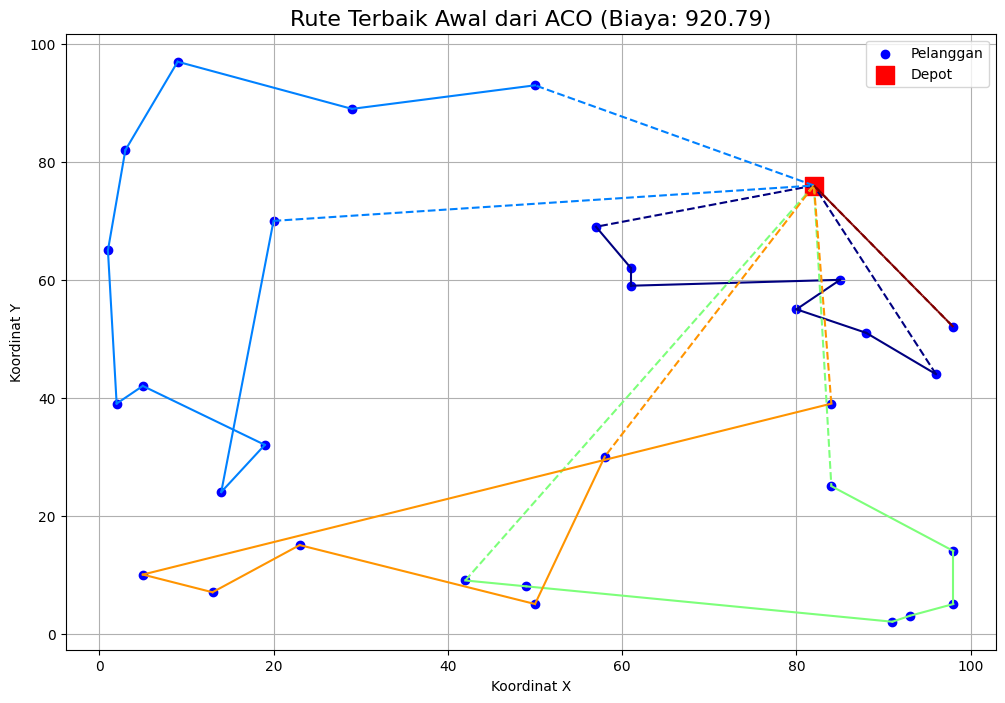

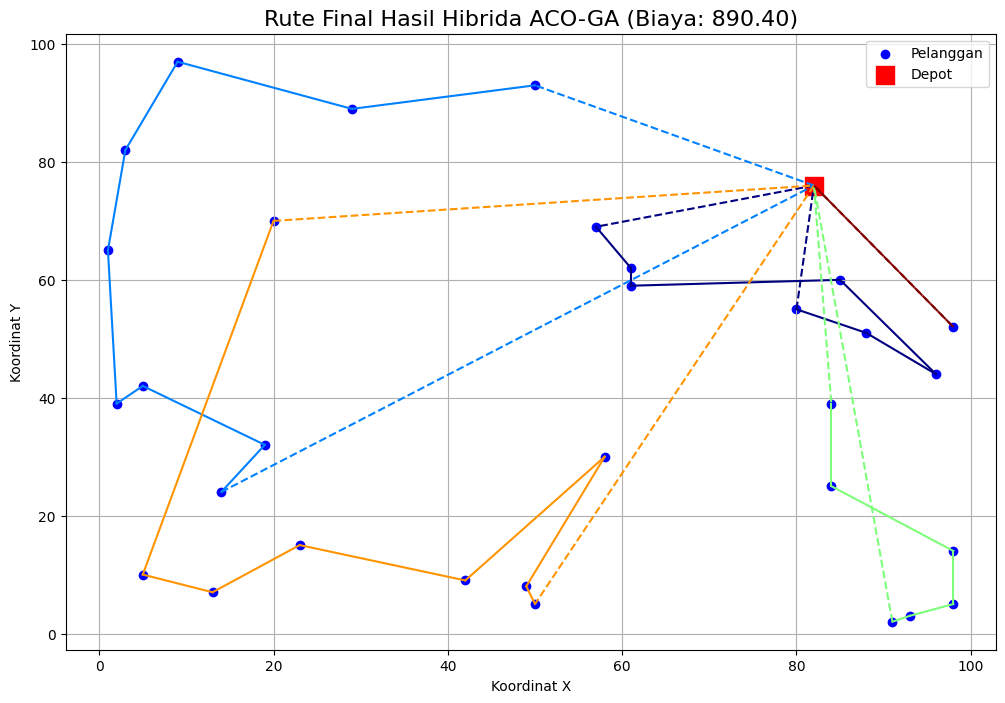

--- Detail Rute Final Terbaik ---
Kendaraan 1: Depot -> 27 -> 24 -> 14 -> 30 -> 1 -> 16 -> 26 -> Depot (Muatan: 100/100)
Kendaraan 2: Depot -> 20 -> 5 -> 25 -> 10 -> 15 -> 9 -> 22 -> 18 -> 8 -> Depot (Muatan: 96/100)
Kendaraan 3: Depot -> 7 -> 13 -> 21 -> 31 -> 19 -> 17 -> Depot (Muatan: 96/100)
Kendaraan 4: Depot -> 2 -> 3 -> 6 -> 23 -> 28 -> 4 -> 11 -> 29 -> Depot (Muatan: 97/100)
Kendaraan 5: Depot -> 12 -> Depot (Muatan: 21/100)


In [10]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import urllib.request
import time

# ==============================================================================
# 1. SETUP DATA DAN PARAMETER (SESUAIKAN DI SINI)
# ==============================================================================
print("===== 1. Memuat Data dan Mengatur Parameter... =====")

# URL Dataset dari VRP-REP
# Dataset: A-n32-k5 (32 lokasi, 5 kendaraan)
# Sumber: http://vrp.galgos.inf.puc-rio.br/index.php/en/
DATASET_URL = "http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp"

# --- Parameter Ant Colony Optimization (ACO) ---
N_ANTS = 20              # Jumlah semut
N_ITERATIONS_ACO = 100   # Jumlah iterasi untuk ACO
ALPHA = 1.0              # Faktor pengaruh feromon
BETA = 5.0               # Faktor pengaruh heuristik (jarak)
RHO = 0.5                # Tingkat penguapan feromon
Q = 100                  # Kuantitas feromon yang disimpan

# --- Parameter Algoritma Genetika (GA) ---
# Ukuran populasi untuk GA diambil dari solusi unik terbaik ACO
N_GENERATIONS_GA = 150   # Jumlah generasi untuk GA
MUTATION_RATE = 0.1      # Probabilitas mutasi
CROSSOVER_RATE = 0.8     # Probabilitas crossover

def load_vrp_data(url):
    """Fungsi untuk mengunduh dan mem-parsing file dataset VRP."""
    print(f"Mengunduh dataset dari: {url}")
    response = urllib.request.urlopen(url)
    data = response.read().decode('utf-8').splitlines()

    dimension = 0
    capacity = 0
    coords = []
    demands = []

    coord_section = False
    demand_section = False

    for line in data:
        if line.startswith("DIMENSION"):
            dimension = int(line.split(":")[1].strip())
        elif line.startswith("CAPACITY"):
            capacity = int(line.split(":")[1].strip())
        elif line.startswith("NODE_COORD_SECTION"):
            coord_section = True
            demand_section = False
            continue
        elif line.startswith("DEMAND_SECTION"):
            coord_section = False
            demand_section = True
            continue
        elif line.startswith("DEPOT_SECTION"):
            break

        if coord_section:
            parts = line.strip().split()
            coords.append((int(parts[1]), int(parts[2])))
        elif demand_section:
            parts = line.strip().split()
            demands.append(int(parts[1]))

    return np.array(coords), np.array(demands), capacity, dimension

# Memuat data
coords, demands, capacity, n_nodes = load_vrp_data(DATASET_URL)
depot_coord = coords[0]

print(f"\nDataset berhasil dimuat:")
print(f" - Jumlah Lokasi (termasuk depot): {n_nodes}")
print(f" - Kapasitas Kendaraan             : {capacity}")
print(f" - Koordinat Depot                 : {depot_coord}")


def calculate_distance_matrix(coordinates):
    """Menghitung matriks jarak Euclidean antar semua node."""
    n = len(coordinates)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            dist = np.linalg.norm(coordinates[i] - coordinates[j])
            dist_matrix[i, j] = dist_matrix[j, i] = dist
    return dist_matrix

distance_matrix = calculate_distance_matrix(coords)
print("\nMatriks jarak antar lokasi berhasil dibuat.\n")


# ==============================================================================
# 2. IMPLEMENTASI ANT COLONY OPTIMIZATION (ACO)
# ==============================================================================
print("===== 2. Menjalankan Ant Colony Optimization (ACO) untuk Solusi Awal =====")

def calculate_total_distance(route, dist_matrix):
    """Menghitung total jarak dari sebuah rute."""
    total_dist = 0
    for sub_route in route:
        # Tambahkan jarak dari depot ke titik pertama dan dari titik terakhir kembali ke depot
        if not sub_route: continue
        total_dist += dist_matrix[0, sub_route[0]]
        for i in range(len(sub_route) - 1):
            total_dist += dist_matrix[sub_route[i], sub_route[i+1]]
        total_dist += dist_matrix[sub_route[-1], 0]
    return total_dist

def run_aco(dist_matrix, demands, capacity):
    """Fungsi utama untuk menjalankan algoritma ACO."""
    n = len(dist_matrix)
    pheromones = np.ones((n, n))  # Inisialisasi feromon
    heuristic_info = 1 / (dist_matrix + 1e-10) # Informasi heuristik (1/jarak)

    all_time_best_solution = (None, float('inf'))
    aco_solutions = []

    for it in range(N_ITERATIONS_ACO):
        all_ant_solutions = []

        for ant in range(N_ANTS):
            # --- Tour Construction ---
            current_solution = []
            current_sub_route = []
            current_load = 0

            # Pelanggan yang belum dikunjungi (selain depot)
            unvisited = list(range(1, n))
            random.shuffle(unvisited)

            while unvisited:
                current_node = 0 if not current_sub_route else current_sub_route[-1]

                # Menemukan pelanggan berikutnya yang valid
                next_node = -1

                # Membangun tabel probabilitas untuk node yang belum dikunjungi
                probs = []
                prob_nodes = []
                for node in unvisited:
                    if demands[node] + current_load <= capacity:
                        tau = pheromones[current_node, node] ** ALPHA
                        eta = heuristic_info[current_node, node] ** BETA
                        probs.append(tau * eta)
                        prob_nodes.append(node)

                if prob_nodes:
                    # Pilih node berikutnya berdasarkan probabilitas
                    total_prob = sum(probs)
                    probs = [p / total_prob for p in probs]
                    next_node = random.choices(prob_nodes, weights=probs, k=1)[0]

                    current_load += demands[next_node]
                    current_sub_route.append(next_node)
                    unvisited.remove(next_node)
                else:
                    # Jika tidak ada node yang muat, kembali ke depot
                    if current_sub_route:
                        current_solution.append(current_sub_route)
                    current_sub_route = []
                    current_load = 0

            if current_sub_route:
                current_solution.append(current_sub_route)

            # Simpan solusi dan biayanya
            distance = calculate_total_distance(current_solution, dist_matrix)
            all_ant_solutions.append((current_solution, distance))

            # Simpan solusi unik untuk populasi awal GA
            # Representasi string untuk memudahkan pengecekan duplikat
            route_str = str(sorted([tuple(sorted(sub)) for sub in current_solution]))
            if (route_str, distance) not in [(str(sorted([tuple(sorted(s)) for s in sol[0]])), sol[1]) for sol in aco_solutions]:
                aco_solutions.append((current_solution, distance))

        # --- Pheromone Update ---
        pheromones *= (1 - RHO) # Evaporasi
        for solution, distance in all_ant_solutions:
            for sub_route in solution:
                if not sub_route: continue
                # Deposit feromon pada jalur yang dilalui
                pheromones[0, sub_route[0]] += Q / distance
                for i in range(len(sub_route) - 1):
                    pheromones[sub_route[i], sub_route[i+1]] += Q / distance
                pheromones[sub_route[-1], 0] += Q / distance

        # Update solusi terbaik sepanjang masa
        best_ant_in_iter = min(all_ant_solutions, key=lambda x: x[1])
        if best_ant_in_iter[1] < all_time_best_solution[1]:
            all_time_best_solution = best_ant_in_iter

    # Urutkan solusi ACO dan ambil yang terbaik untuk populasi GA
    aco_solutions.sort(key=lambda x: x[1])
    return all_time_best_solution, aco_solutions

# Jalankan ACO
t0 = time.time()
best_aco_solution, initial_population_raw = run_aco(distance_matrix, demands, capacity)
print(f"ACO selesai dalam {time.time() - t0:.3f} detik.")
print(f" - Rute terbaik dari ACO: Biaya = {best_aco_solution[1]:.2f}")
print(f" - Jumlah solusi unik ditemukan untuk populasi GA: {len(initial_population_raw)}\n")

# Siapkan populasi untuk GA (hanya rutenya)
initial_population = [sol[0] for sol in initial_population_raw]

# ==============================================================================
# 3. IMPLEMENTASI ALGORITMA GENETIKA (GA)
# ==============================================================================
print("===== 3. Menyempurnakan Rute dengan Algoritma Genetika (GA) =====")

def flatten_route(route):
    """Mengubah format rute dari list of lists menjadi satu list."""
    return [node for sub_route in route for node in sub_route]

def re_create_route(flat_route, demands, capacity):
    """Membentuk kembali rute terstruktur dari list datar, dengan memperhatikan kapasitas."""
    new_route = []
    current_sub_route = []
    current_load = 0
    for node in flat_route:
        if current_load + demands[node] <= capacity:
            current_sub_route.append(node)
            current_load += demands[node]
        else:
            new_route.append(current_sub_route)
            current_sub_route = [node]
            current_load = demands[node]
    if current_sub_route:
        new_route.append(current_sub_route)
    return new_route

def crossover(parent1, parent2, demands, capacity):
    """Ordered Crossover (OX1) yang diadaptasi untuk VRP."""
    if random.random() > CROSSOVER_RATE:
        return parent1, parent2

    p1_flat = flatten_route(parent1)
    p2_flat = flatten_route(parent2)
    size = len(p1_flat)

    # Pilih dua titik potong acak
    start, end = sorted(random.sample(range(size), 2))

    # Buat anak dengan segmen dari parent1
    child1_flat = [None] * size
    child1_flat[start:end] = p1_flat[start:end]

    # Isi sisa gen dari parent2
    p2_pointer = end
    c1_pointer = end
    while None in child1_flat:
        if p2_flat[p2_pointer % size] not in child1_flat:
            child1_flat[c1_pointer % size] = p2_flat[p2_pointer % size]
            c1_pointer += 1
        p2_pointer += 1

    # Proses yang sama untuk anak kedua
    child2_flat = [None] * size
    child2_flat[start:end] = p2_flat[start:end]
    p1_pointer = end
    c2_pointer = end
    while None in child2_flat:
        if p1_flat[p1_pointer % size] not in child2_flat:
            child2_flat[c2_pointer % size] = p1_flat[p1_pointer % size]
            c2_pointer += 1
        p1_pointer += 1

    return re_create_route(child1_flat, demands, capacity), re_create_route(child2_flat, demands, capacity)


def mutate(route, demands, capacity):
    """Swap Mutation: menukar posisi dua pelanggan secara acak."""
    if random.random() > MUTATION_RATE:
        return route

    flat_route = flatten_route(route)
    if len(flat_route) < 2:
        return route

    # Pilih dua indeks acak untuk ditukar
    idx1, idx2 = random.sample(range(len(flat_route)), 2)
    flat_route[idx1], flat_route[idx2] = flat_route[idx2], flat_route[idx1]

    return re_create_route(flat_route, demands, capacity)

def run_ga(initial_pop, dist_matrix, demands, capacity):
    """Fungsi utama untuk menjalankan Algoritma Genetika."""
    population = initial_pop
    best_solution_ga = (None, float('inf'))

    for gen in range(N_GENERATIONS_GA):
        # Evaluasi populasi
        pop_with_fitness = []
        for individual in population:
            dist = calculate_total_distance(individual, dist_matrix)
            pop_with_fitness.append((individual, 1/dist)) # Fitness = 1 / Jarak
            # Update solusi terbaik
            if dist < best_solution_ga[1]:
                best_solution_ga = (individual, dist)

        # --- Seleksi (Tournament Selection) ---
        next_gen = []
        # Elitisme: Bawa individu terbaik langsung ke generasi berikutnya
        best_individual = min(pop_with_fitness, key=lambda x: -x[1])[0]
        next_gen.append(best_individual)

        while len(next_gen) < len(population):
            # Pilih dua pasangan untuk turnamen
            p1 = random.choice(pop_with_fitness)
            p2 = random.choice(pop_with_fitness)
            parent1 = p1[0] if p1[1] > p2[1] else p2[0]

            p3 = random.choice(pop_with_fitness)
            p4 = random.choice(pop_with_fitness)
            parent2 = p3[0] if p3[1] > p4[1] else p4[0]

            # --- Crossover dan Mutasi ---
            child1, child2 = crossover(parent1, parent2, demands, capacity)
            child1 = mutate(child1, demands, capacity)
            child2 = mutate(child2, demands, capacity)

            next_gen.extend([child1, child2])

        population = next_gen[:len(initial_pop)] # Pastikan ukuran populasi konstan

    return best_solution_ga


# Jalankan GA
t0 = time.time()
# Gunakan N populasi terbaik dari ACO
POPULATION_SIZE_GA = min(len(initial_population), 50)
final_best_solution = run_ga(initial_population[:POPULATION_SIZE_GA], distance_matrix, demands, capacity)
print(f"GA selesai dalam {time.time() - t0:.3f} detik.")


# ==============================================================================
# 4. HASIL AKHIR DAN VISUALISASI
# ==============================================================================
print("\n===== 4. Hasil Akhir Optimasi =====")
print(f"Biaya (Jarak) Awal Terbaik dari ACO : {best_aco_solution[1]:.2f}")
print(f"Biaya (Jarak) Final Terbaik dari GA : {final_best_solution[1]:.2f}")

improvement = ((best_aco_solution[1] - final_best_solution[1]) / best_aco_solution[1]) * 100
print(f"Peningkatan Kualitas Solusi         : {improvement:.2f}%\n")


def plot_solution(coords, solution, title):
    """Fungsi untuk memvisualisasikan rute solusi."""
    plt.figure(figsize=(12, 8))
    # Plot semua lokasi pelanggan
    plt.scatter(coords[1:, 0], coords[1:, 1], c='blue', label='Pelanggan')
    # Plot depot
    plt.scatter(coords[0, 0], coords[0, 1], c='red', s=150, marker='s', label='Depot')

    colors = plt.cm.jet(np.linspace(0, 1, len(solution)))

    for i, sub_route in enumerate(solution):
        if not sub_route: continue

        # Rute dari depot ke titik pertama
        start_node = coords[0]
        end_node = coords[sub_route[0]]
        plt.plot([start_node[0], end_node[0]], [start_node[1], end_node[1]], color=colors[i], linestyle='--')

        # Rute antar pelanggan
        for j in range(len(sub_route) - 1):
            start_node = coords[sub_route[j]]
            end_node = coords[sub_route[j+1]]
            plt.plot([start_node[0], end_node[0]], [start_node[1], end_node[1]], color=colors[i])

        # Rute dari titik terakhir kembali ke depot
        start_node = coords[sub_route[-1]]
        end_node = coords[0]
        plt.plot([start_node[0], end_node[0]], [start_node[1], end_node[1]], color=colors[i], linestyle='--')

    plt.title(title, fontsize=16)
    plt.xlabel("Koordinat X")
    plt.ylabel("Koordinat Y")
    plt.legend()
    plt.grid(True)
    plt.show()

# Menampilkan Rute Terbaik Hasil ACO
plot_solution(coords, best_aco_solution[0], f"Rute Terbaik Awal dari ACO (Biaya: {best_aco_solution[1]:.2f})")

# Menampilkan Rute Final Hasil Hibrida ACO-GA
plot_solution(coords, final_best_solution[0], f"Rute Final Hasil Hibrida ACO-GA (Biaya: {final_best_solution[1]:.2f})")

# Menampilkan detail rute final
print("--- Detail Rute Final Terbaik ---")
for i, sub_route in enumerate(final_best_solution[0]):
    route_str = "Depot -> " + " -> ".join(map(str, sub_route)) + " -> Depot"
    load = sum(demands[node] for node in sub_route)
    print(f"Kendaraan {i+1}: {route_str} (Muatan: {load}/{capacity})")



===== 5. Skenario Pengujian dengan Variasi Parameter dan Dataset =====

--- Pengujian Dataset: A-n32-k5 ---
Parameter ACO: {'ALPHA': 1.0, 'BETA': 5.0, 'RHO': 0.5}
Parameter GA: {'N_GENERATIONS_GA': 150, 'MUTATION_RATE': 0.1, 'CROSSOVER_RATE': 0.8}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp


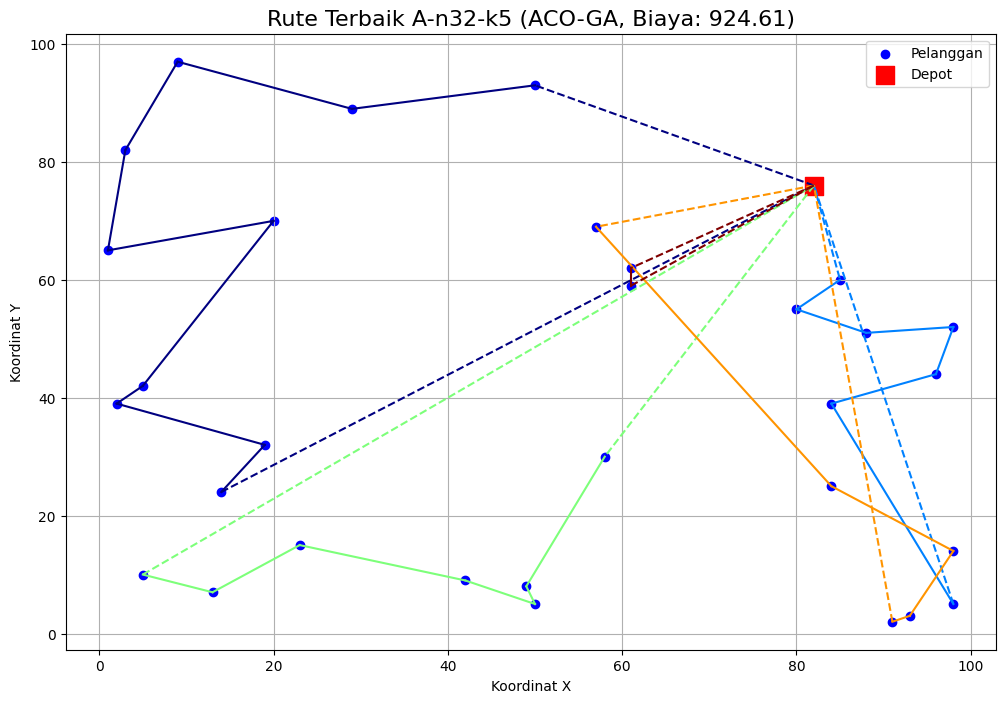


--- Pengujian Dataset: A-n32-k5 ---
Parameter ACO: {'ALPHA': 1.0, 'BETA': 5.0, 'RHO': 0.5}
Parameter GA: {'N_GENERATIONS_GA': 200, 'MUTATION_RATE': 0.05, 'CROSSOVER_RATE': 0.9}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp


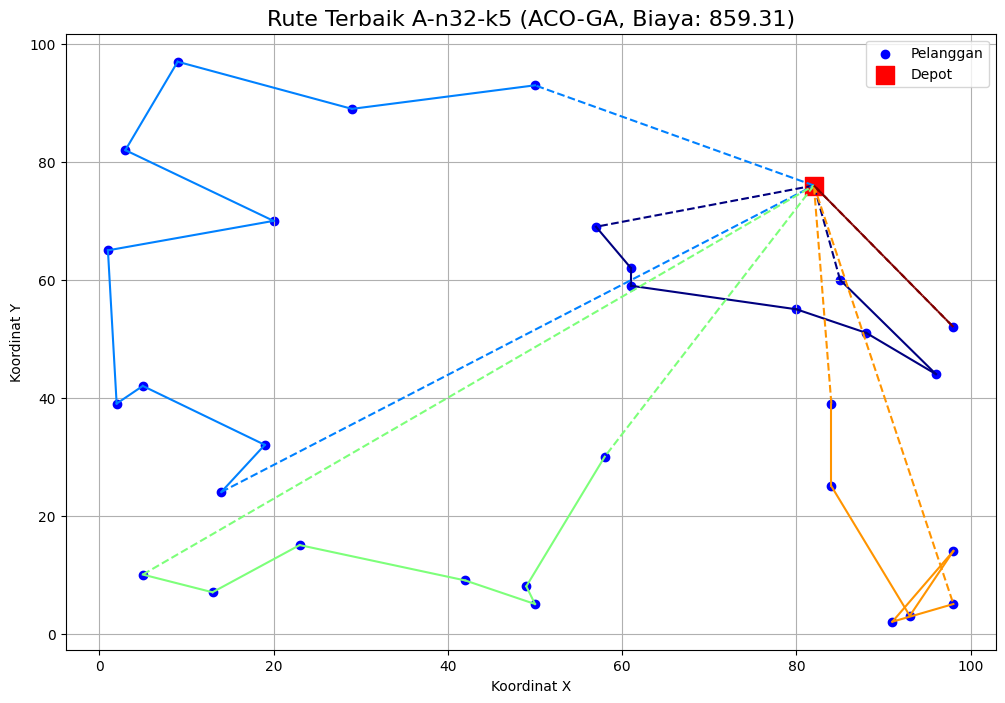


--- Pengujian Dataset: A-n32-k5 ---
Parameter ACO: {'ALPHA': 1.0, 'BETA': 5.0, 'RHO': 0.5}
Parameter GA: {'N_GENERATIONS_GA': 100, 'MUTATION_RATE': 0.2, 'CROSSOVER_RATE': 0.7}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp


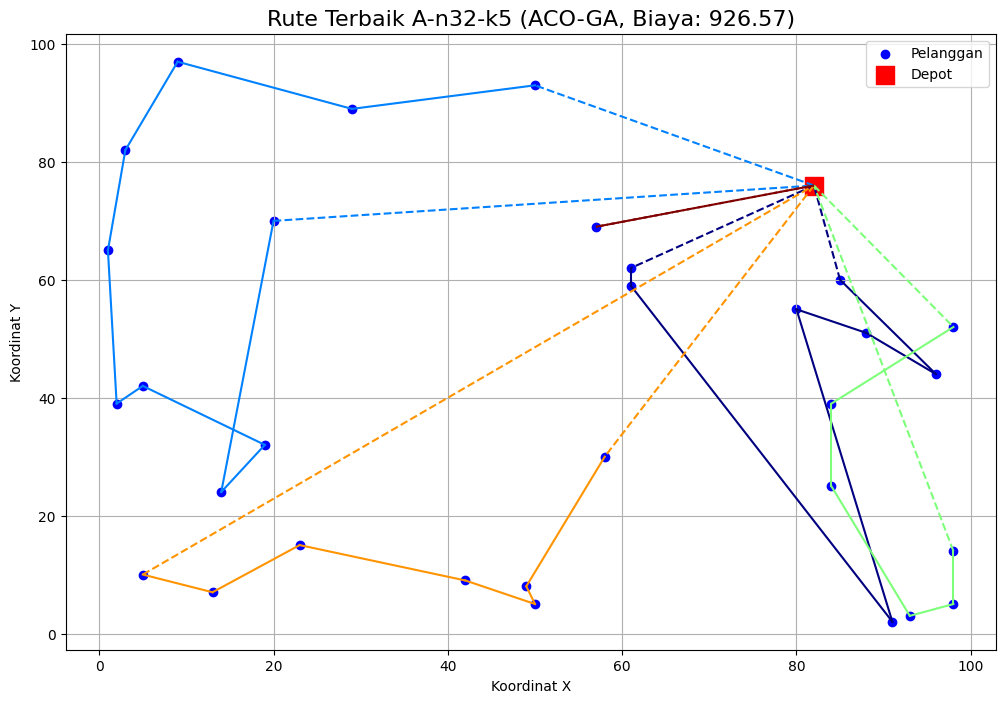


--- Pengujian Dataset: A-n32-k5 ---
Parameter ACO: {'ALPHA': 2.0, 'BETA': 3.0, 'RHO': 0.3}
Parameter GA: {'N_GENERATIONS_GA': 150, 'MUTATION_RATE': 0.1, 'CROSSOVER_RATE': 0.8}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp


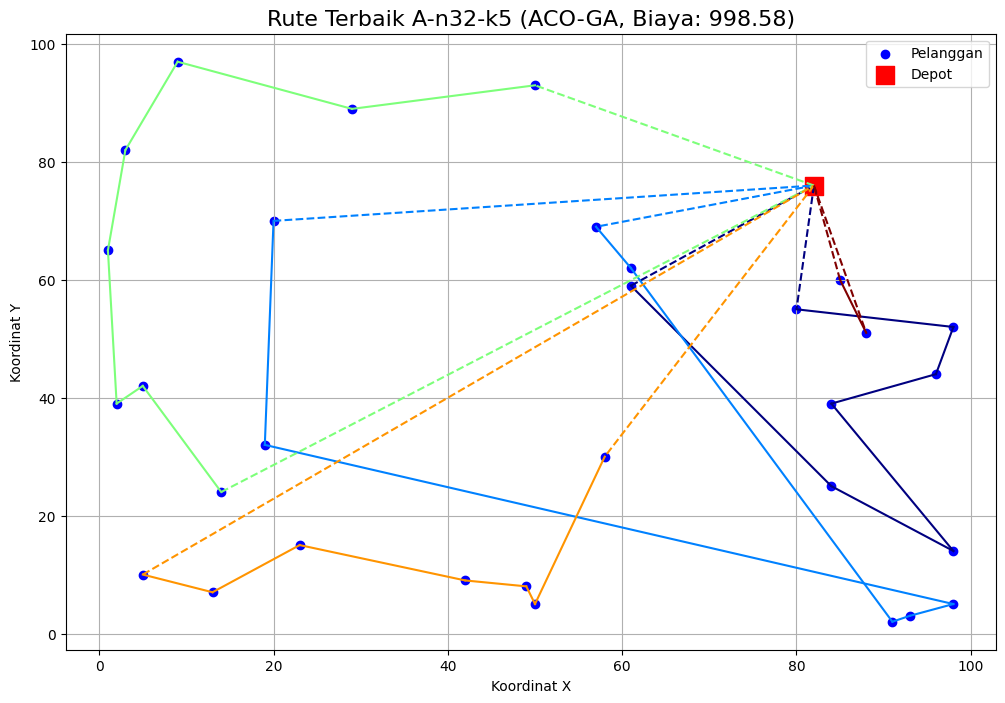


--- Pengujian Dataset: A-n32-k5 ---
Parameter ACO: {'ALPHA': 2.0, 'BETA': 3.0, 'RHO': 0.3}
Parameter GA: {'N_GENERATIONS_GA': 200, 'MUTATION_RATE': 0.05, 'CROSSOVER_RATE': 0.9}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp


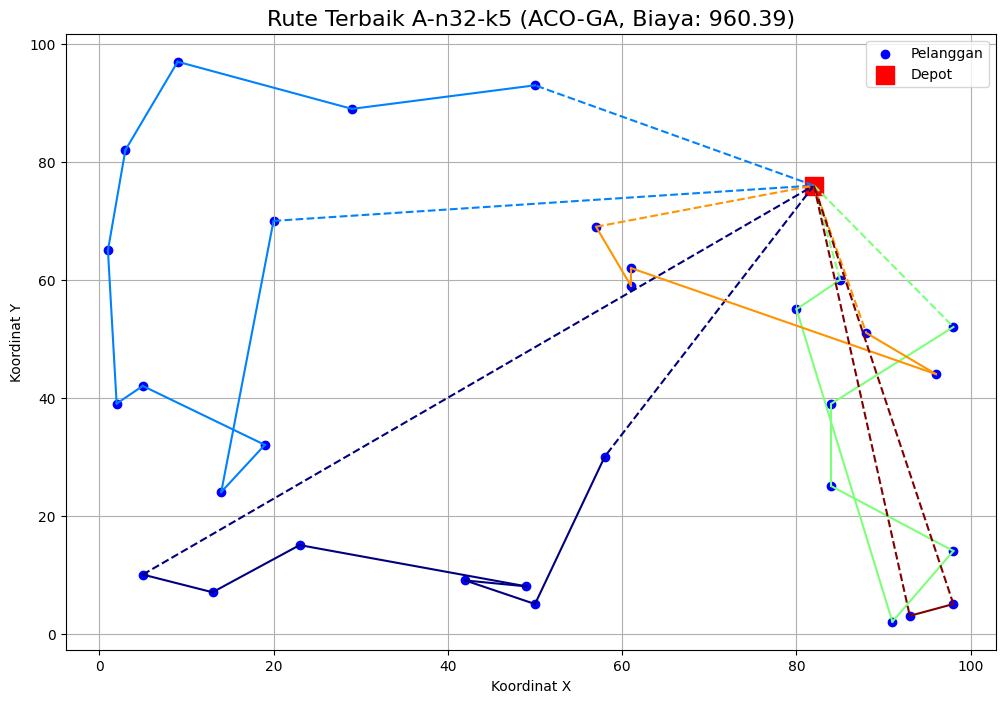


--- Pengujian Dataset: A-n32-k5 ---
Parameter ACO: {'ALPHA': 2.0, 'BETA': 3.0, 'RHO': 0.3}
Parameter GA: {'N_GENERATIONS_GA': 100, 'MUTATION_RATE': 0.2, 'CROSSOVER_RATE': 0.7}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp


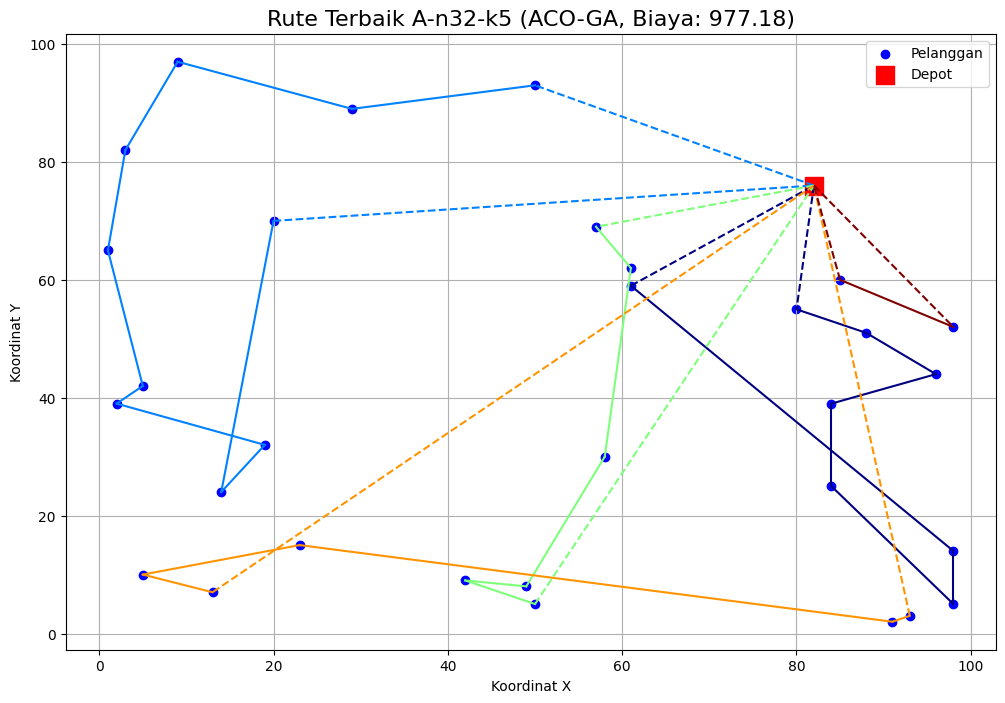


--- Pengujian Dataset: A-n32-k5 ---
Parameter ACO: {'ALPHA': 0.5, 'BETA': 7.0, 'RHO': 0.7}
Parameter GA: {'N_GENERATIONS_GA': 150, 'MUTATION_RATE': 0.1, 'CROSSOVER_RATE': 0.8}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp


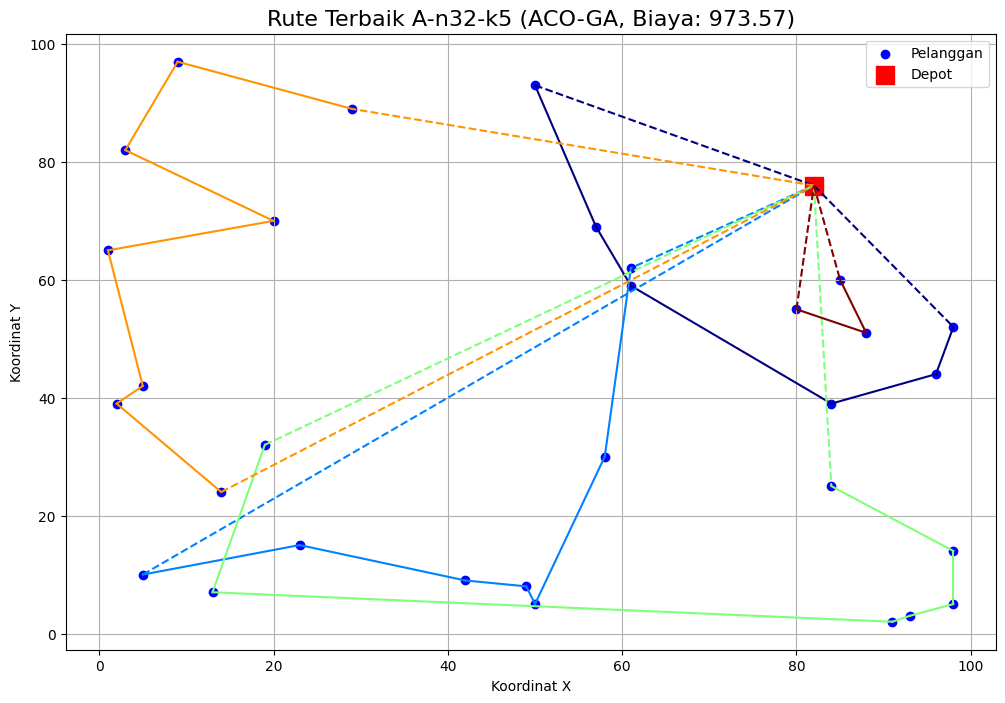


--- Pengujian Dataset: A-n32-k5 ---
Parameter ACO: {'ALPHA': 0.5, 'BETA': 7.0, 'RHO': 0.7}
Parameter GA: {'N_GENERATIONS_GA': 200, 'MUTATION_RATE': 0.05, 'CROSSOVER_RATE': 0.9}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp


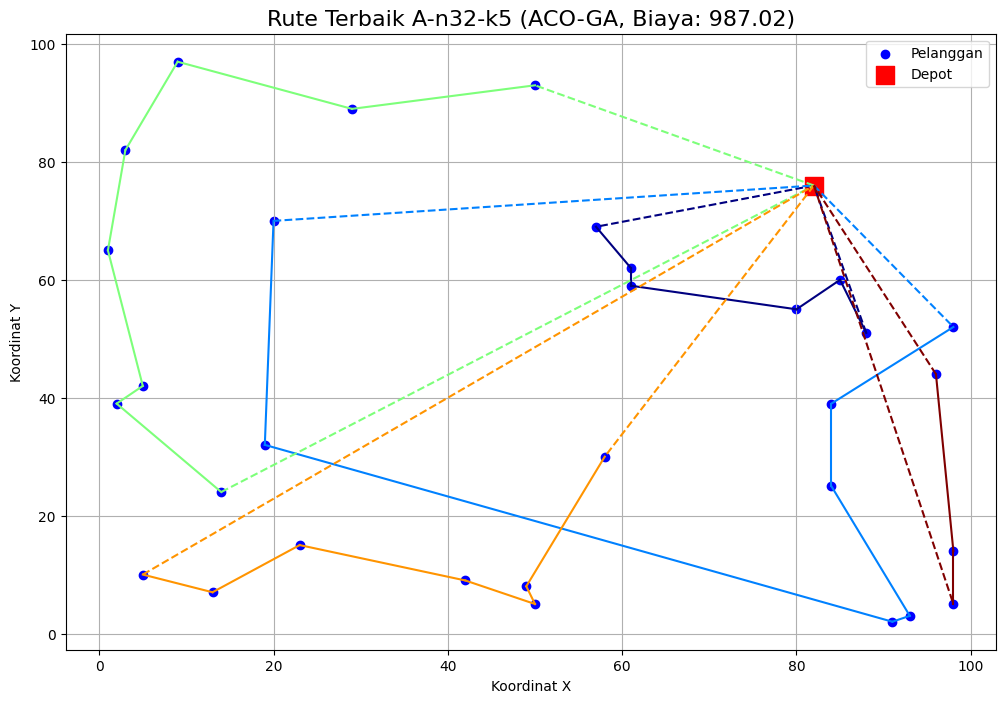


--- Pengujian Dataset: A-n32-k5 ---
Parameter ACO: {'ALPHA': 0.5, 'BETA': 7.0, 'RHO': 0.7}
Parameter GA: {'N_GENERATIONS_GA': 100, 'MUTATION_RATE': 0.2, 'CROSSOVER_RATE': 0.7}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp


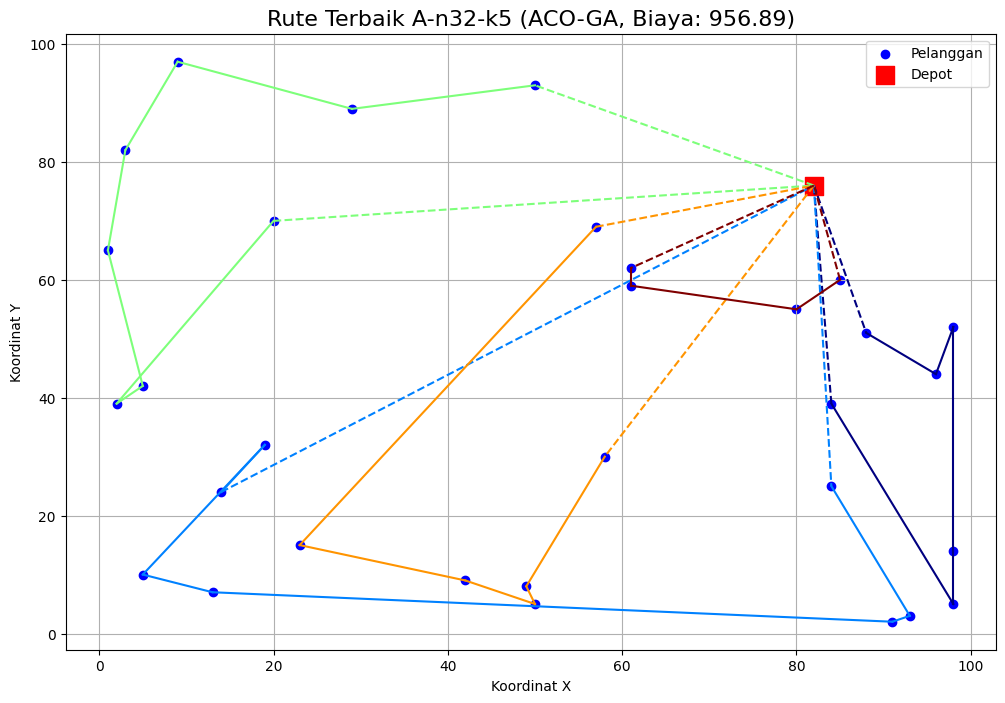


--- Pengujian Dataset: A-n37-k6 ---
Parameter ACO: {'ALPHA': 1.0, 'BETA': 5.0, 'RHO': 0.5}
Parameter GA: {'N_GENERATIONS_GA': 150, 'MUTATION_RATE': 0.1, 'CROSSOVER_RATE': 0.8}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n37-k6.vrp


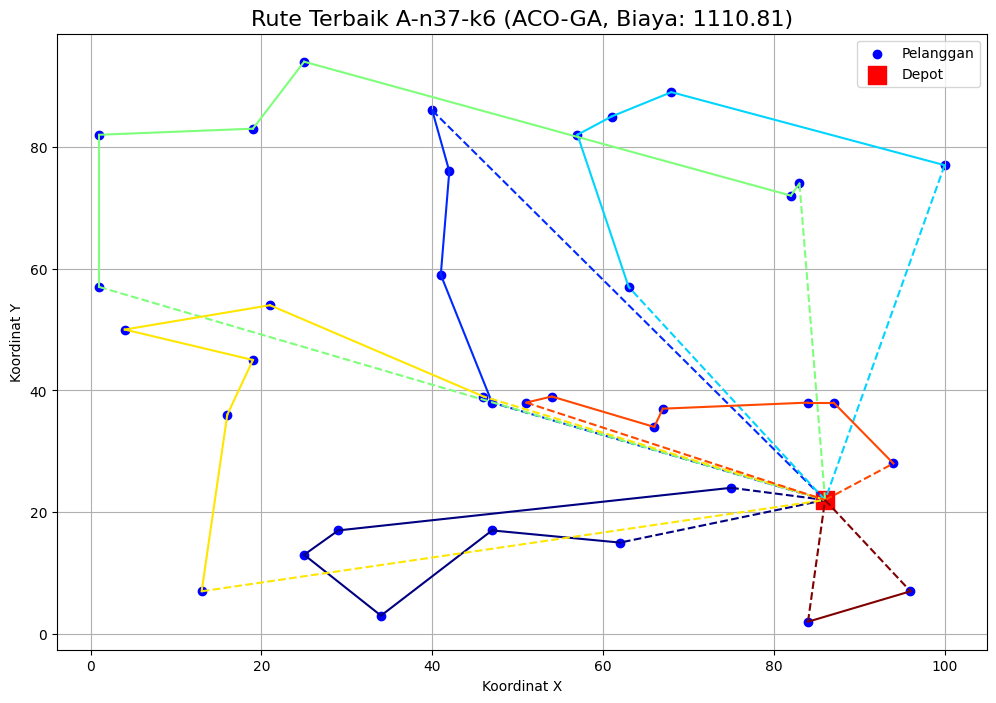


--- Pengujian Dataset: A-n37-k6 ---
Parameter ACO: {'ALPHA': 1.0, 'BETA': 5.0, 'RHO': 0.5}
Parameter GA: {'N_GENERATIONS_GA': 200, 'MUTATION_RATE': 0.05, 'CROSSOVER_RATE': 0.9}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n37-k6.vrp


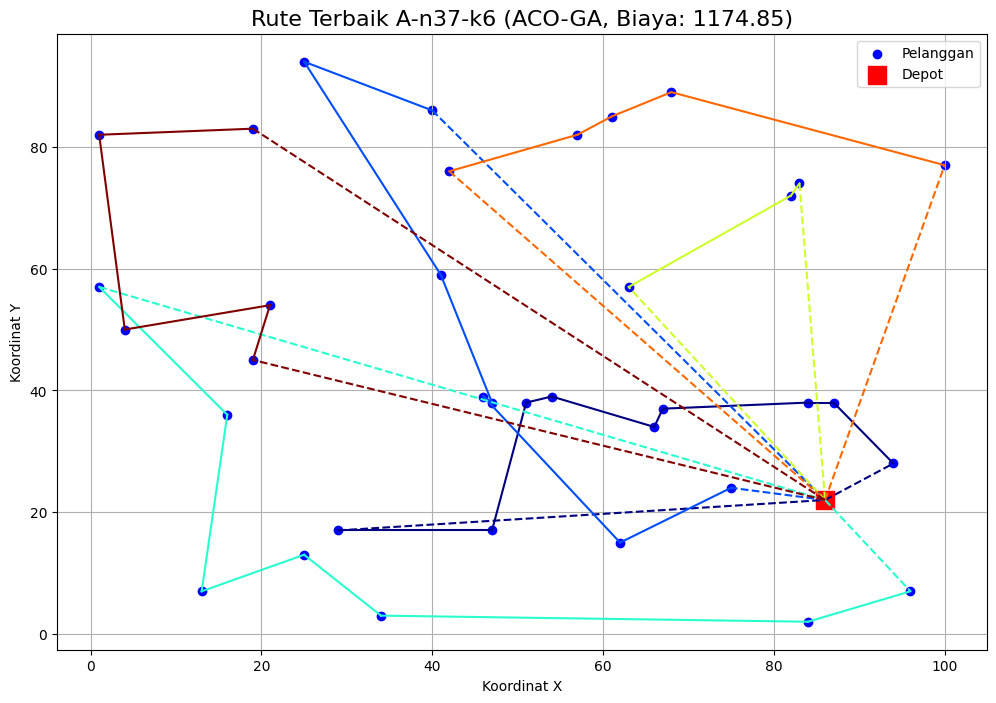


--- Pengujian Dataset: A-n37-k6 ---
Parameter ACO: {'ALPHA': 1.0, 'BETA': 5.0, 'RHO': 0.5}
Parameter GA: {'N_GENERATIONS_GA': 100, 'MUTATION_RATE': 0.2, 'CROSSOVER_RATE': 0.7}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n37-k6.vrp


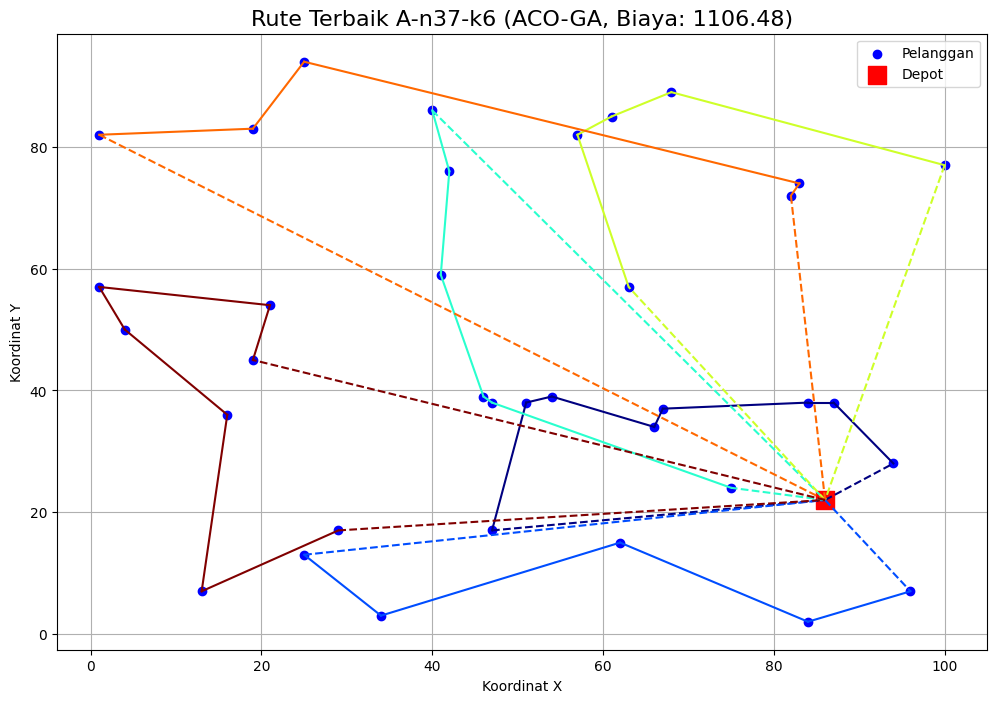


--- Pengujian Dataset: A-n37-k6 ---
Parameter ACO: {'ALPHA': 2.0, 'BETA': 3.0, 'RHO': 0.3}
Parameter GA: {'N_GENERATIONS_GA': 150, 'MUTATION_RATE': 0.1, 'CROSSOVER_RATE': 0.8}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n37-k6.vrp


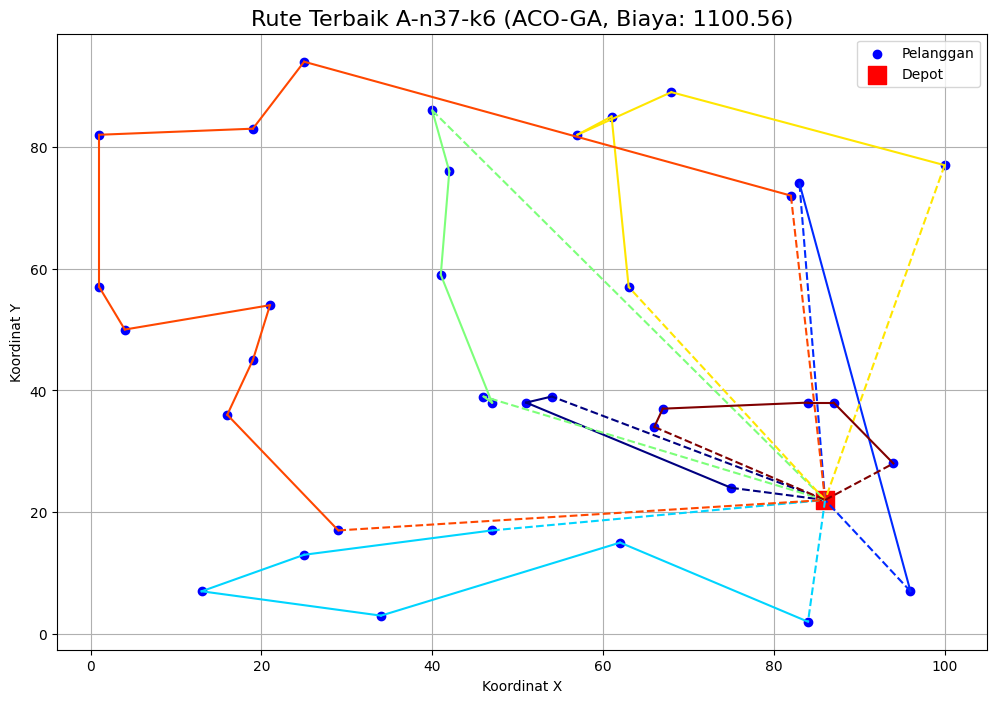


--- Pengujian Dataset: A-n37-k6 ---
Parameter ACO: {'ALPHA': 2.0, 'BETA': 3.0, 'RHO': 0.3}
Parameter GA: {'N_GENERATIONS_GA': 200, 'MUTATION_RATE': 0.05, 'CROSSOVER_RATE': 0.9}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n37-k6.vrp


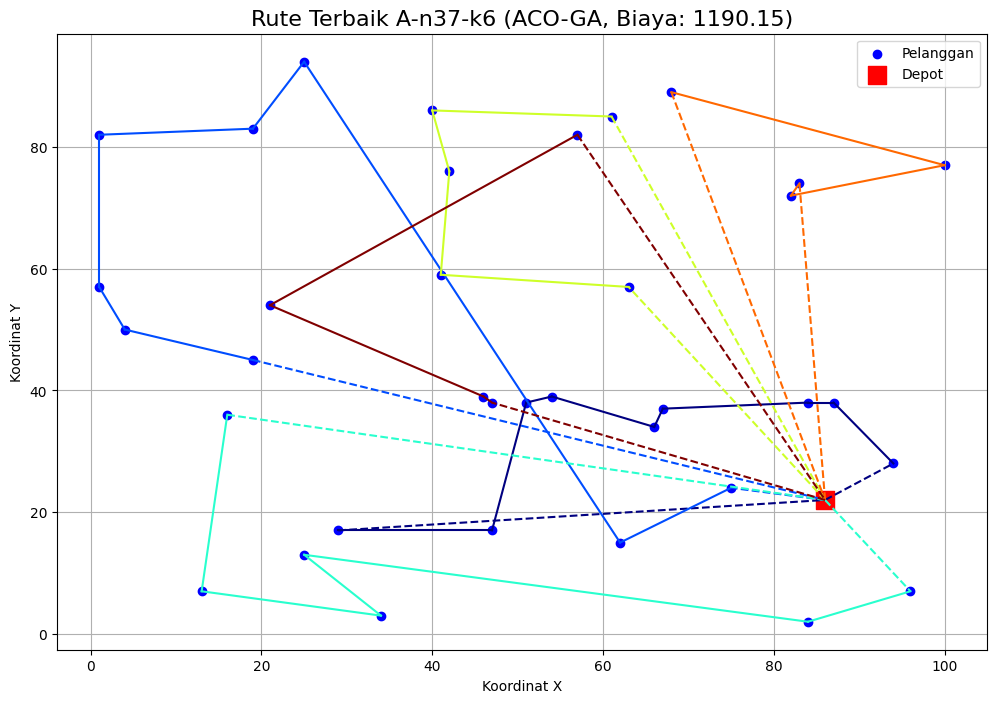


--- Pengujian Dataset: A-n37-k6 ---
Parameter ACO: {'ALPHA': 2.0, 'BETA': 3.0, 'RHO': 0.3}
Parameter GA: {'N_GENERATIONS_GA': 100, 'MUTATION_RATE': 0.2, 'CROSSOVER_RATE': 0.7}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n37-k6.vrp


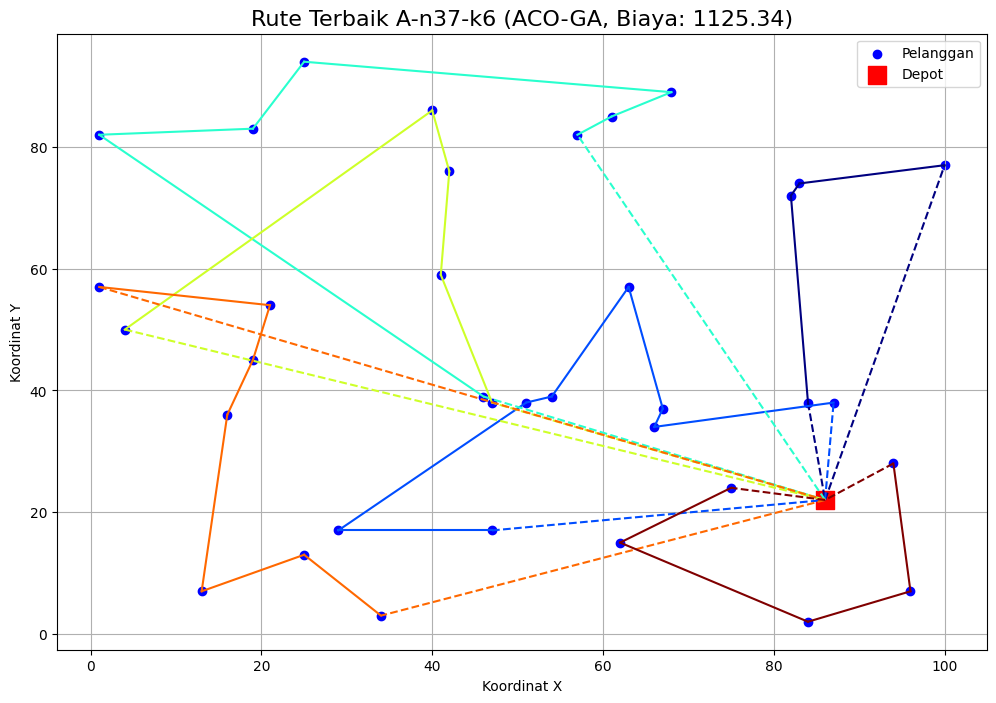


--- Pengujian Dataset: A-n37-k6 ---
Parameter ACO: {'ALPHA': 0.5, 'BETA': 7.0, 'RHO': 0.7}
Parameter GA: {'N_GENERATIONS_GA': 150, 'MUTATION_RATE': 0.1, 'CROSSOVER_RATE': 0.8}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n37-k6.vrp


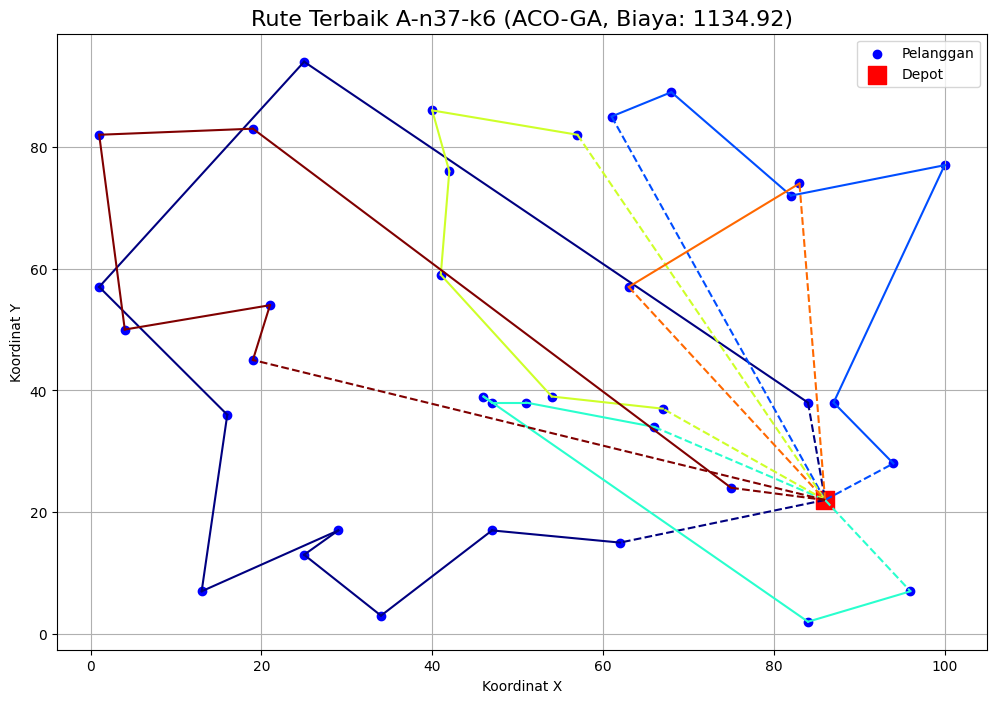


--- Pengujian Dataset: A-n37-k6 ---
Parameter ACO: {'ALPHA': 0.5, 'BETA': 7.0, 'RHO': 0.7}
Parameter GA: {'N_GENERATIONS_GA': 200, 'MUTATION_RATE': 0.05, 'CROSSOVER_RATE': 0.9}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n37-k6.vrp


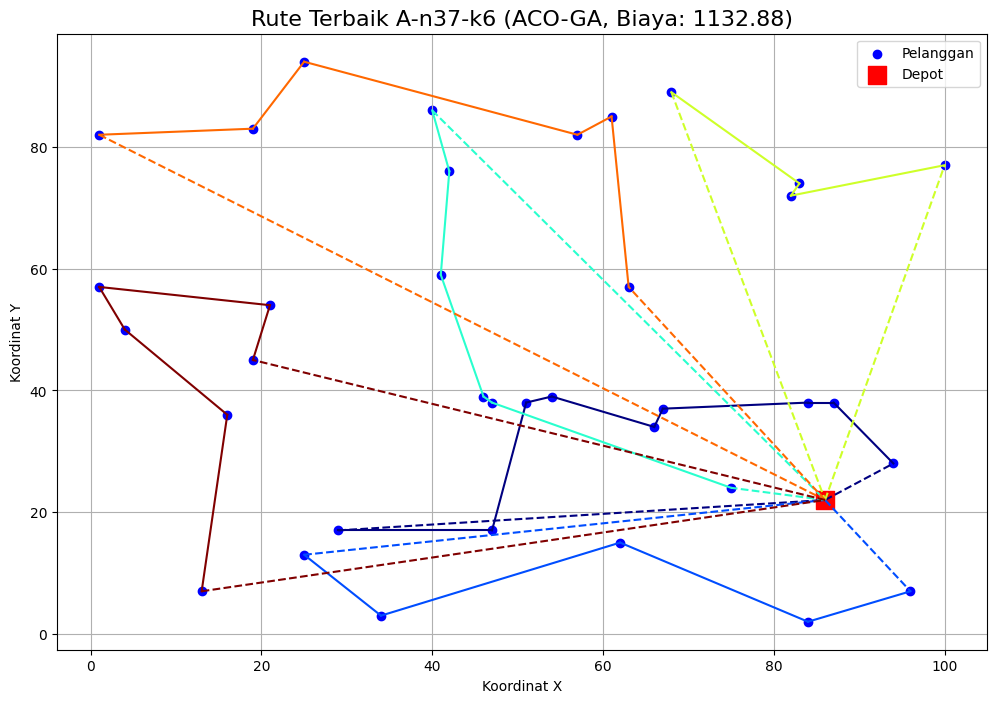


--- Pengujian Dataset: A-n37-k6 ---
Parameter ACO: {'ALPHA': 0.5, 'BETA': 7.0, 'RHO': 0.7}
Parameter GA: {'N_GENERATIONS_GA': 100, 'MUTATION_RATE': 0.2, 'CROSSOVER_RATE': 0.7}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n37-k6.vrp


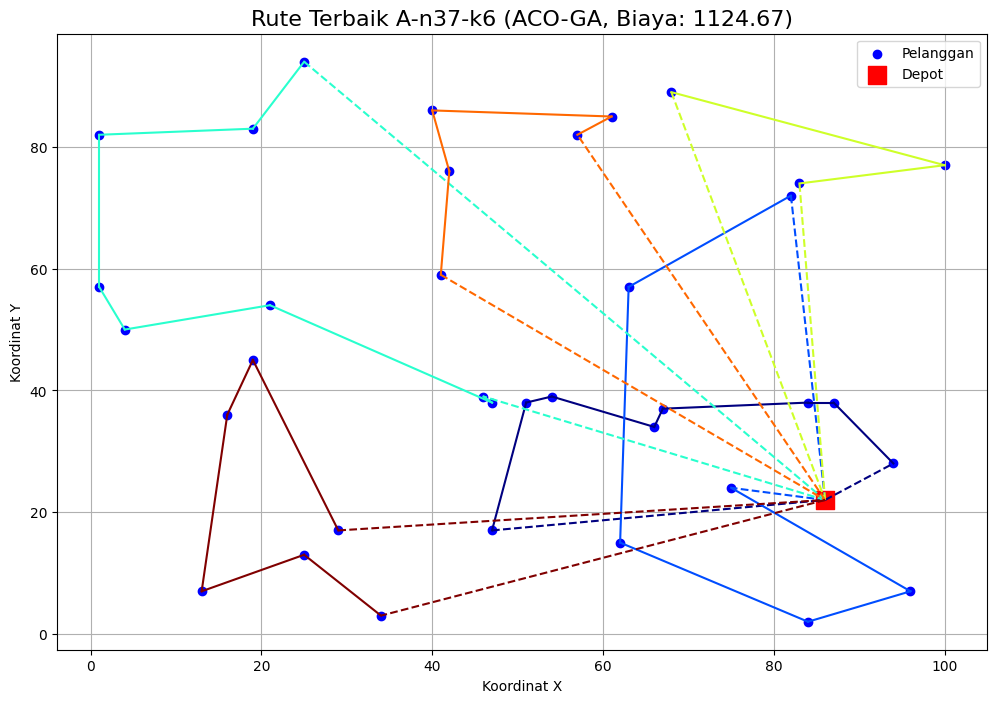


--- Pengujian Dataset: A-n45-k7 ---
Parameter ACO: {'ALPHA': 1.0, 'BETA': 5.0, 'RHO': 0.5}
Parameter GA: {'N_GENERATIONS_GA': 150, 'MUTATION_RATE': 0.1, 'CROSSOVER_RATE': 0.8}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n45-k7.vrp


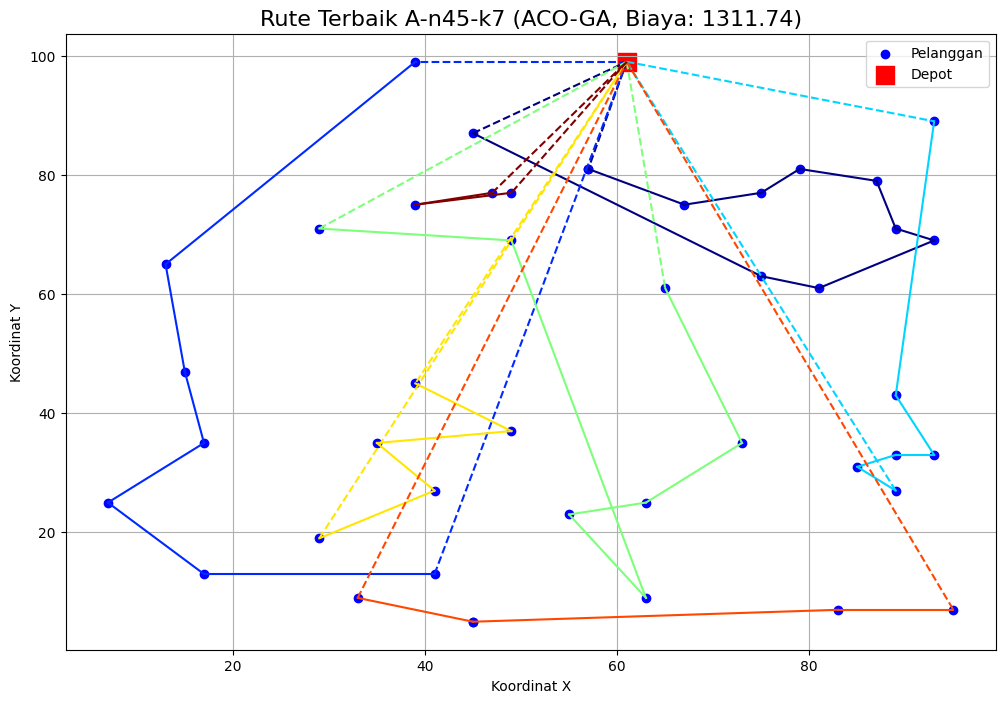


--- Pengujian Dataset: A-n45-k7 ---
Parameter ACO: {'ALPHA': 1.0, 'BETA': 5.0, 'RHO': 0.5}
Parameter GA: {'N_GENERATIONS_GA': 200, 'MUTATION_RATE': 0.05, 'CROSSOVER_RATE': 0.9}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n45-k7.vrp


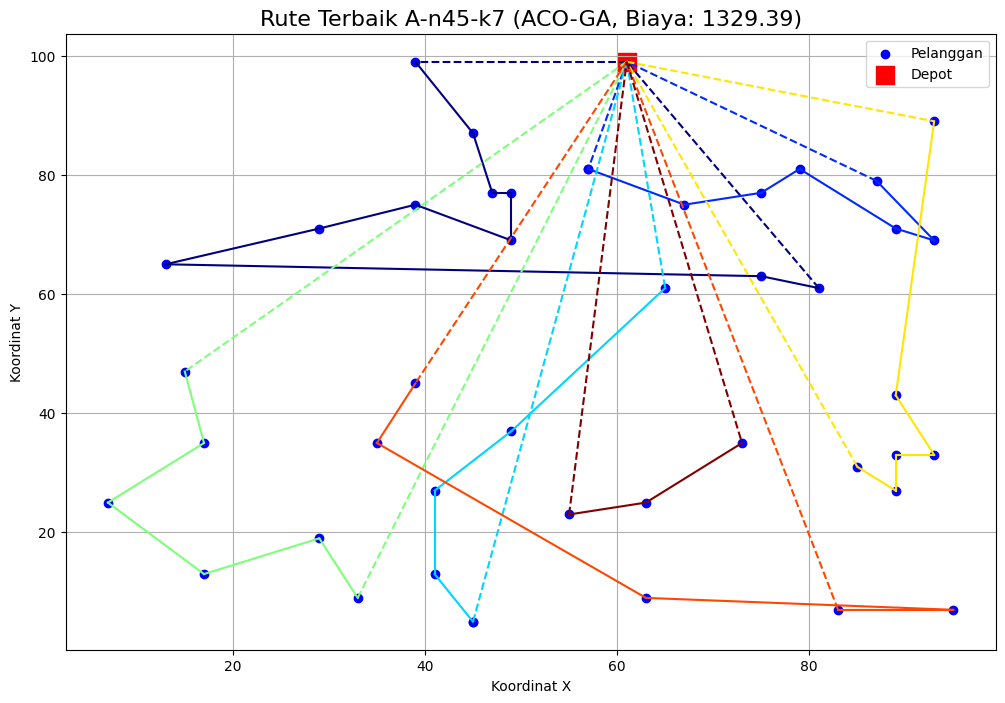


--- Pengujian Dataset: A-n45-k7 ---
Parameter ACO: {'ALPHA': 1.0, 'BETA': 5.0, 'RHO': 0.5}
Parameter GA: {'N_GENERATIONS_GA': 100, 'MUTATION_RATE': 0.2, 'CROSSOVER_RATE': 0.7}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n45-k7.vrp


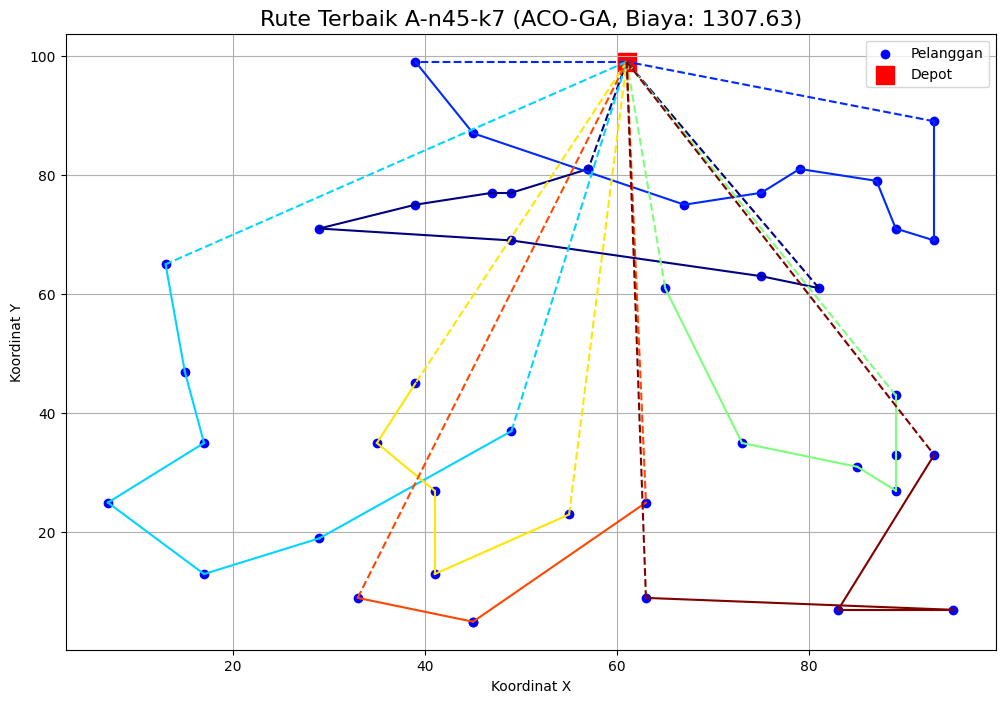


--- Pengujian Dataset: A-n45-k7 ---
Parameter ACO: {'ALPHA': 2.0, 'BETA': 3.0, 'RHO': 0.3}
Parameter GA: {'N_GENERATIONS_GA': 150, 'MUTATION_RATE': 0.1, 'CROSSOVER_RATE': 0.8}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n45-k7.vrp


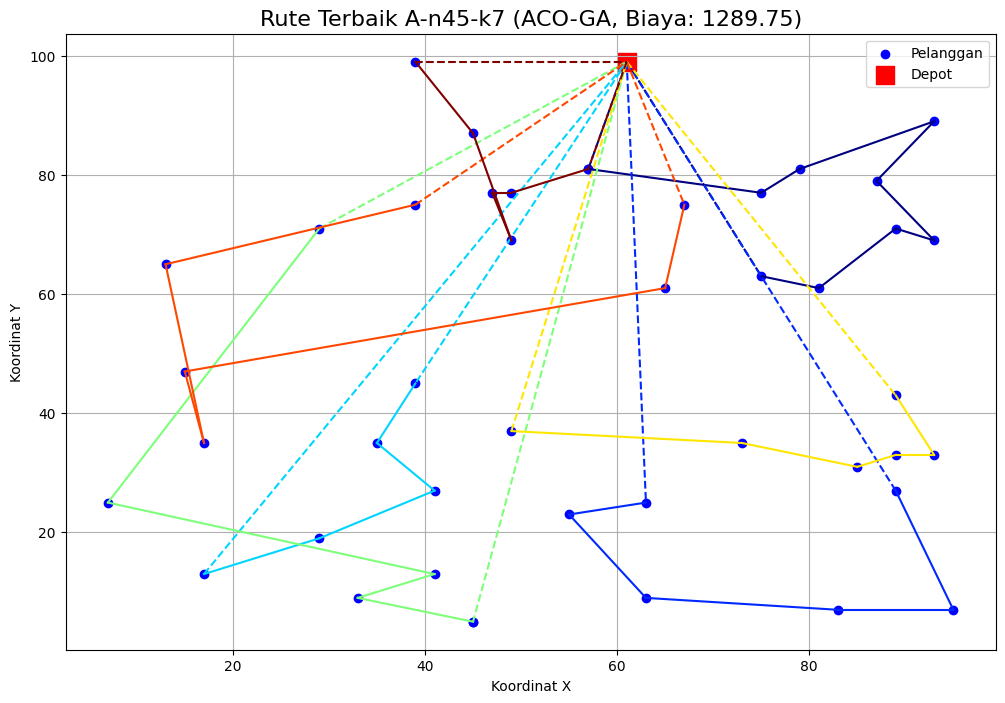


--- Pengujian Dataset: A-n45-k7 ---
Parameter ACO: {'ALPHA': 2.0, 'BETA': 3.0, 'RHO': 0.3}
Parameter GA: {'N_GENERATIONS_GA': 200, 'MUTATION_RATE': 0.05, 'CROSSOVER_RATE': 0.9}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n45-k7.vrp


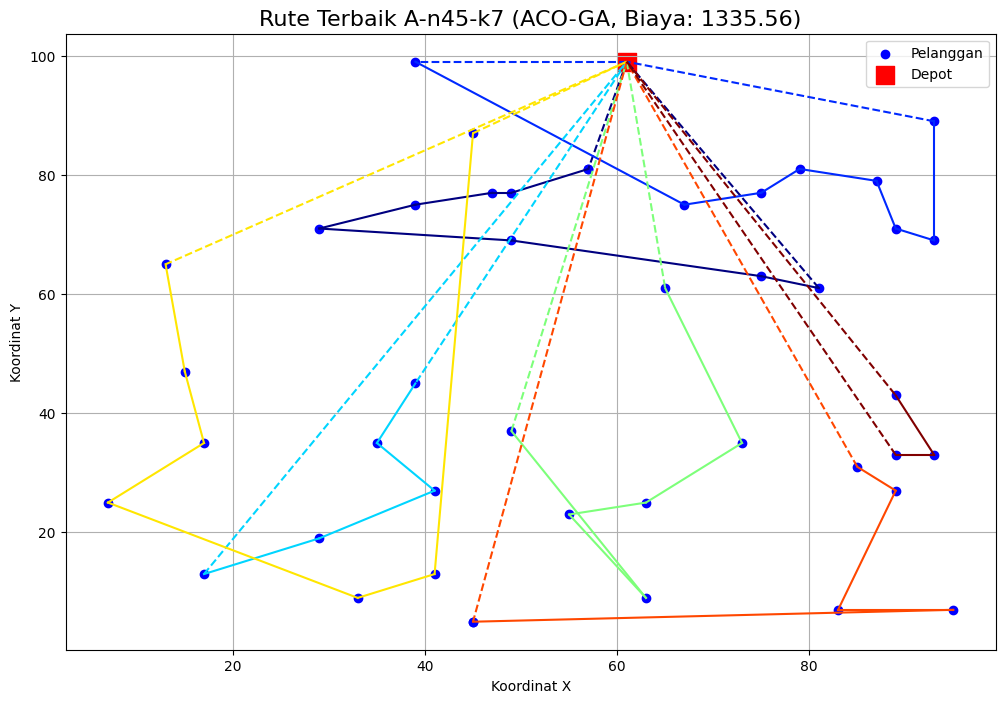


--- Pengujian Dataset: A-n45-k7 ---
Parameter ACO: {'ALPHA': 2.0, 'BETA': 3.0, 'RHO': 0.3}
Parameter GA: {'N_GENERATIONS_GA': 100, 'MUTATION_RATE': 0.2, 'CROSSOVER_RATE': 0.7}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n45-k7.vrp


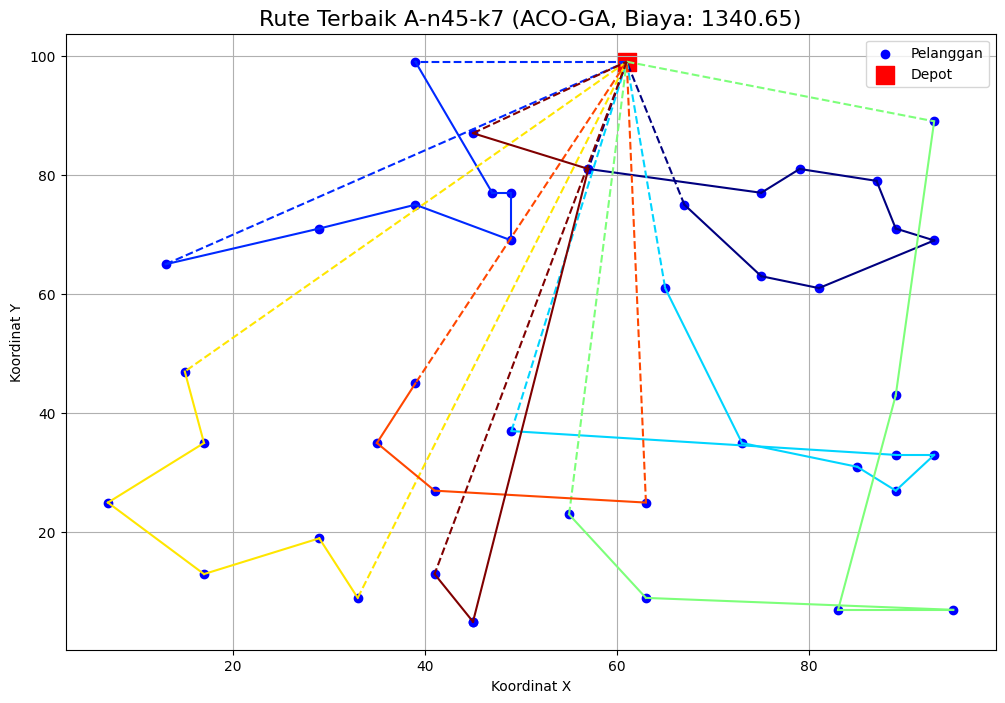


--- Pengujian Dataset: A-n45-k7 ---
Parameter ACO: {'ALPHA': 0.5, 'BETA': 7.0, 'RHO': 0.7}
Parameter GA: {'N_GENERATIONS_GA': 150, 'MUTATION_RATE': 0.1, 'CROSSOVER_RATE': 0.8}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n45-k7.vrp


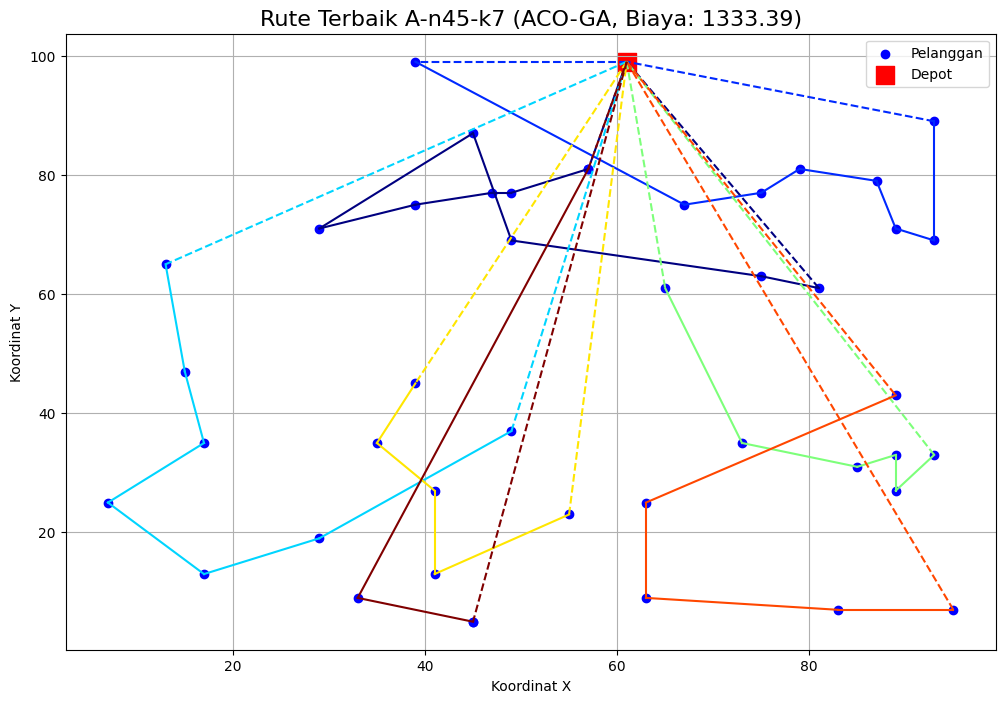


--- Pengujian Dataset: A-n45-k7 ---
Parameter ACO: {'ALPHA': 0.5, 'BETA': 7.0, 'RHO': 0.7}
Parameter GA: {'N_GENERATIONS_GA': 200, 'MUTATION_RATE': 0.05, 'CROSSOVER_RATE': 0.9}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n45-k7.vrp


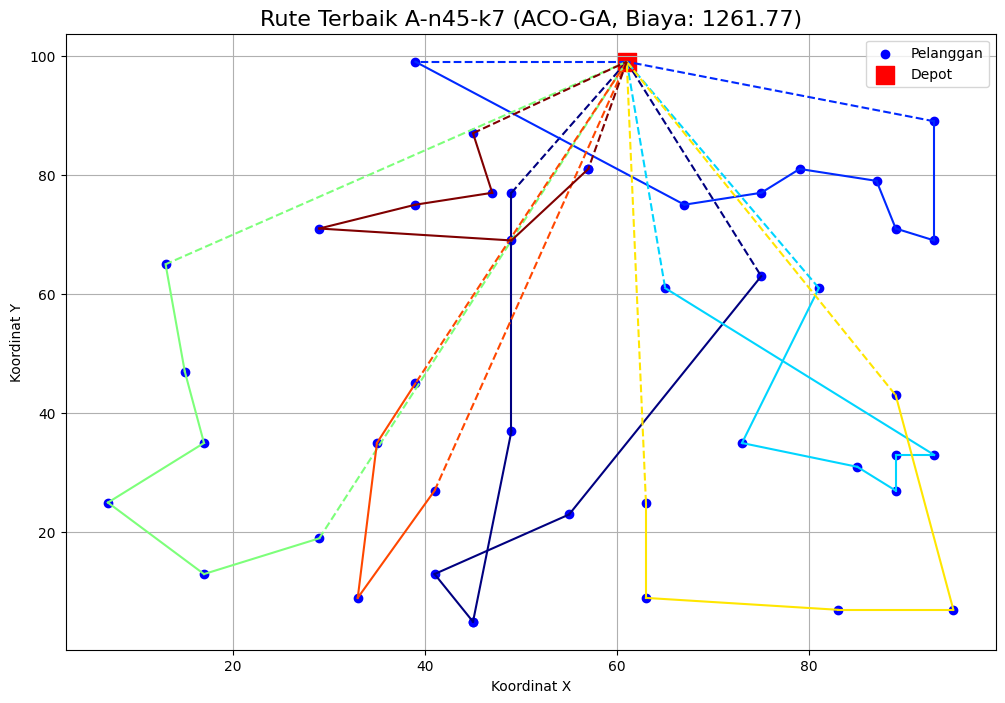


--- Pengujian Dataset: A-n45-k7 ---
Parameter ACO: {'ALPHA': 0.5, 'BETA': 7.0, 'RHO': 0.7}
Parameter GA: {'N_GENERATIONS_GA': 100, 'MUTATION_RATE': 0.2, 'CROSSOVER_RATE': 0.7}
Mengunduh dataset dari: http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n45-k7.vrp


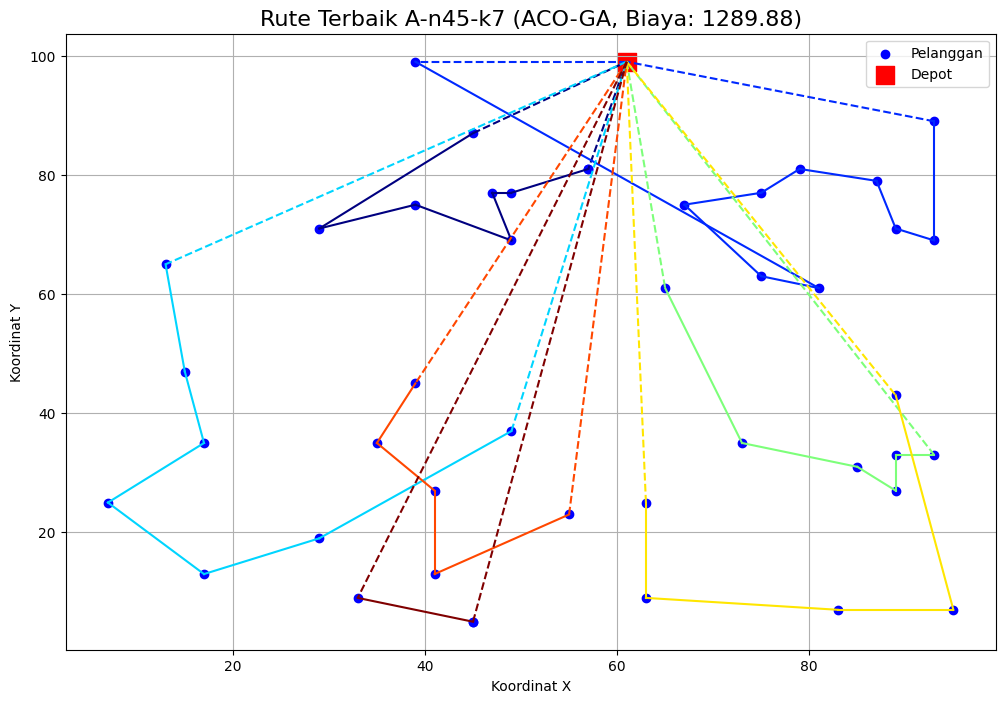


===== Ringkasan Hasil Pengujian =====
Scenario     Dataset    ACO Cost   GA Cost    Improvement (%) ACO Time (s) GA Time (s)  Total Time (s)
------------------------------------------------------------------------------------------
A-n32-k5_ACO1_GA1 A-n32-k5   946.84     924.61     2.35            8.317        0.296        8.613       
A-n32-k5_ACO1_GA2 A-n32-k5   865.47     859.31     0.71            9.059        0.429        9.488       
A-n32-k5_ACO1_GA3 A-n32-k5   937.22     926.57     1.14            8.693        0.184        8.877       
A-n32-k5_ACO2_GA1 A-n32-k5   1002.68    998.58     0.41            5.468        0.304        5.771       
A-n32-k5_ACO2_GA2 A-n32-k5   962.95     960.39     0.27            7.661        0.451        8.111       
A-n32-k5_ACO2_GA3 A-n32-k5   1005.53    977.18     2.82            8.132        0.213        8.346       
A-n32-k5_ACO3_GA1 A-n32-k5   984.87     973.57     1.15            11.584       0.312        11.896      
A-n32-k5_ACO3_GA2 A-n32-k

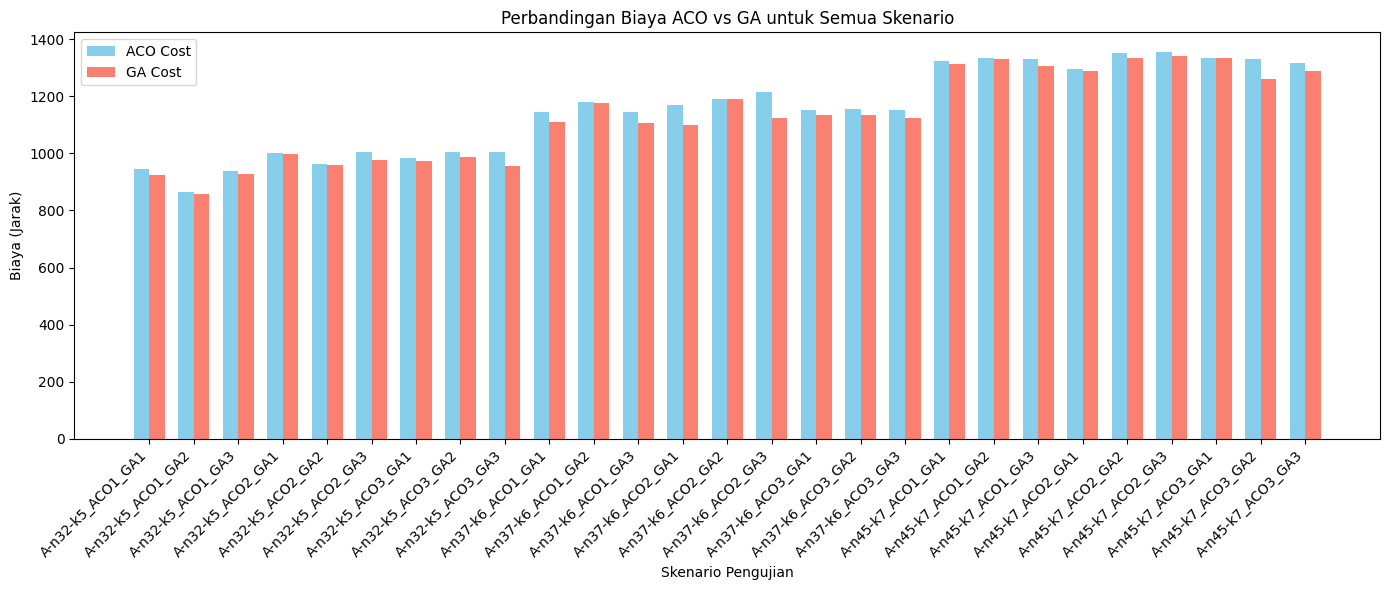

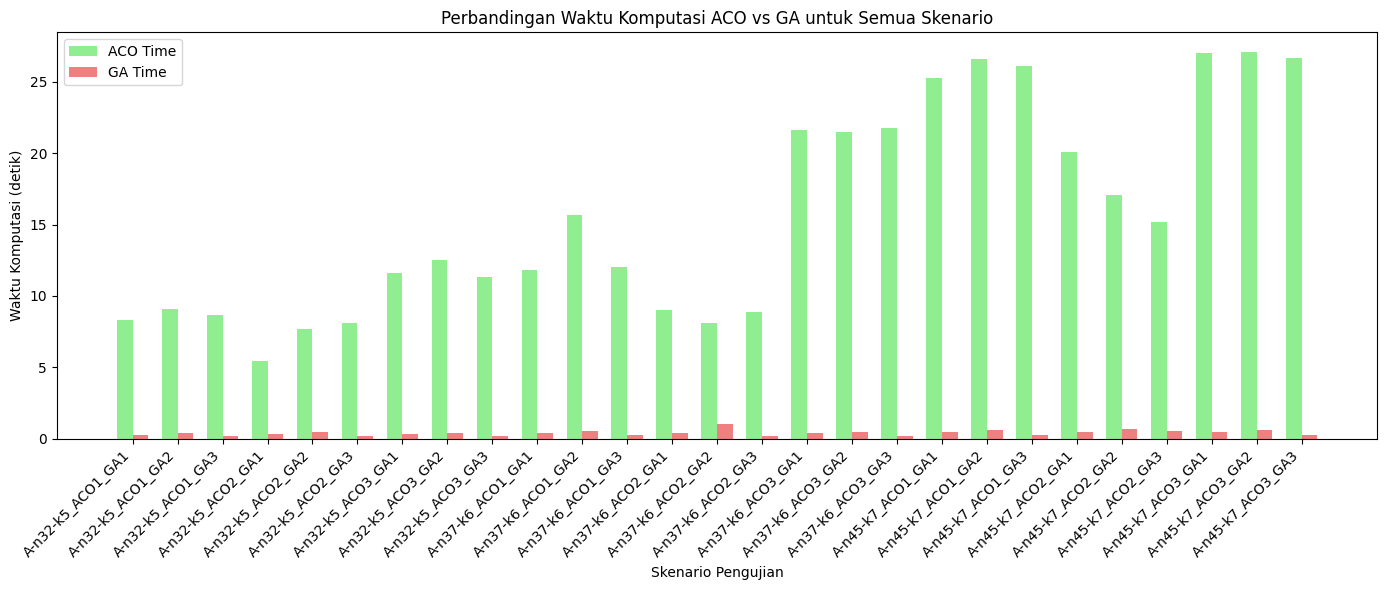

In [12]:
# ==============================================================================
# 5. SKENARIO PENGUJIAN
# ==============================================================================
print("\n===== 5. Skenario Pengujian dengan Variasi Parameter dan Dataset =====")

# Daftar dataset tambahan untuk pengujian
DATASET_URLS = {
    "A-n32-k5": "http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp",
    "A-n37-k6": "http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n37-k6.vrp",
    "A-n45-k7": "http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n45-k7.vrp"
}

# Variasi parameter untuk pengujian
ACO_PARAM_CONFIGS = [
    {"ALPHA": 1.0, "BETA": 5.0, "RHO": 0.5},
    {"ALPHA": 2.0, "BETA": 3.0, "RHO": 0.3},
    {"ALPHA": 0.5, "BETA": 7.0, "RHO": 0.7}
]

GA_PARAM_CONFIGS = [
    {"N_GENERATIONS_GA": 150, "MUTATION_RATE": 0.1, "CROSSOVER_RATE": 0.8},
    {"N_GENERATIONS_GA": 200, "MUTATION_RATE": 0.05, "CROSSOVER_RATE": 0.9},
    {"N_GENERATIONS_GA": 100, "MUTATION_RATE": 0.2, "CROSSOVER_RATE": 0.7}
]

# Fungsi untuk menjalankan pengujian
def run_test_scenario(dataset_url, dataset_name, aco_params, ga_params):
    """Menjalankan satu skenario pengujian untuk dataset dan parameter tertentu."""
    print(f"\n--- Pengujian Dataset: {dataset_name} ---")
    print(f"Parameter ACO: {aco_params}")
    print(f"Parameter GA: {ga_params}")

    # Override parameter global untuk pengujian
    global ALPHA, BETA, RHO, N_GENERATIONS_GA, MUTATION_RATE, CROSSOVER_RATE
    ALPHA = aco_params["ALPHA"]
    BETA = aco_params["BETA"]
    RHO = aco_params["RHO"]
    N_GENERATIONS_GA = ga_params["N_GENERATIONS_GA"]
    MUTATION_RATE = ga_params["MUTATION_RATE"]
    CROSSOVER_RATE = ga_params["CROSSOVER_RATE"]

    # Muat dataset
    coords, demands, capacity, n_nodes = load_vrp_data(dataset_url)
    distance_matrix = calculate_distance_matrix(coords)

    # Jalankan ACO
    t0 = time.time()
    best_aco_solution, initial_population_raw = run_aco(distance_matrix, demands, capacity)
    aco_time = time.time() - t0

    # Siapkan populasi untuk GA
    initial_population = [sol[0] for sol in initial_population_raw]
    POPULATION_SIZE_GA = min(len(initial_population), 50)

    # Jalankan GA
    t1 = time.time()
    final_best_solution = run_ga(initial_population[:POPULATION_SIZE_GA], distance_matrix, demands, capacity)
    ga_time = time.time() - t1

    # Hitung peningkatan kualitas solusi
    improvement = ((best_aco_solution[1] - final_best_solution[1]) / best_aco_solution[1]) * 100 if best_aco_solution[1] > 0 else 0

    # Simpan hasil
    result = {
        "dataset": dataset_name,
        "aco_cost": best_aco_solution[1],
        "ga_cost": final_best_solution[1],
        "improvement": improvement,
        "aco_time": aco_time,
        "ga_time": ga_time,
        "total_time": aco_time + ga_time,
        "aco_params": aco_params,
        "ga_params": ga_params
    }

    # Visualisasi rute terbaik untuk skenario ini
    plot_solution(coords, final_best_solution[0],
                  f"Rute Terbaik {dataset_name} (ACO-GA, Biaya: {final_best_solution[1]:.2f})")

    return result

# Menjalankan semua skenario pengujian
test_results = []
for dataset_name, dataset_url in DATASET_URLS.items():
    for i, aco_params in enumerate(ACO_PARAM_CONFIGS):
        for j, ga_params in enumerate(GA_PARAM_CONFIGS):
            result = run_test_scenario(dataset_url, dataset_name, aco_params, ga_params)
            result["scenario_id"] = f"{dataset_name}_ACO{i+1}_GA{j+1}"
            test_results.append(result)

# Menampilkan hasil pengujian dalam tabel yang lebih jelas
print("\n===== Ringkasan Hasil Pengujian =====")
print(f"{'Scenario':<12} {'Dataset':<10} {'ACO Cost':<10} {'GA Cost':<10} {'Improvement (%)':<15} {'ACO Time (s)':<12} {'GA Time (s)':<12} {'Total Time (s)':<12}")
print("-" * 90)
for result in test_results:
    print(f"{result['scenario_id']:<12} {result['dataset']:<10} {result['aco_cost']:<10.2f} {result['ga_cost']:<10.2f} {result['improvement']:<15.2f} {result['aco_time']:<12.3f} {result['ga_time']:<12.3f} {result['total_time']:<12.3f}")

# Visualisasi perbandingan biaya
plt.figure(figsize=(14, 6))
scenarios = [result["scenario_id"] for result in test_results]
aco_costs = [result['aco_cost'] for result in test_results]
ga_costs = [result['ga_cost'] for result in test_results]
x = np.arange(len(scenarios))
width = 0.35

plt.bar(x - width/2, aco_costs, width, label='ACO Cost', color='skyblue')
plt.bar(x + width/2, ga_costs, width, label='GA Cost', color='salmon')
plt.xlabel('Skenario Pengujian')
plt.ylabel('Biaya (Jarak)')
plt.title('Perbandingan Biaya ACO vs GA untuk Semua Skenario')
plt.xticks(x, scenarios, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Visualisasi waktu komputasi
plt.figure(figsize=(14, 6))
aco_times = [result['aco_time'] for result in test_results]
ga_times = [result['ga_time'] for result in test_results]
plt.bar(x - width/2, aco_times, width, label='ACO Time', color='lightgreen')
plt.bar(x + width/2, ga_times, width, label='GA Time', color='lightcoral')
plt.xlabel('Skenario Pengujian')
plt.ylabel('Waktu Komputasi (detik)')
plt.title('Perbandingan Waktu Komputasi ACO vs GA untuk Semua Skenario')
plt.xticks(x, scenarios, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()